# Understanding Supervised Learning Models: Logistic Regression, SVM, and Decision Tree


# 1. LOGISTIC REGRESSION

### 1. Data Loading and Exploration

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
bankMarketing = pd.read_csv("portuguese_bank_marketing_numeric_random_subsampled.csv", encoding="utf-8")

### 2. Calculate correlation between target variable 'y' and other features

<Axes: >

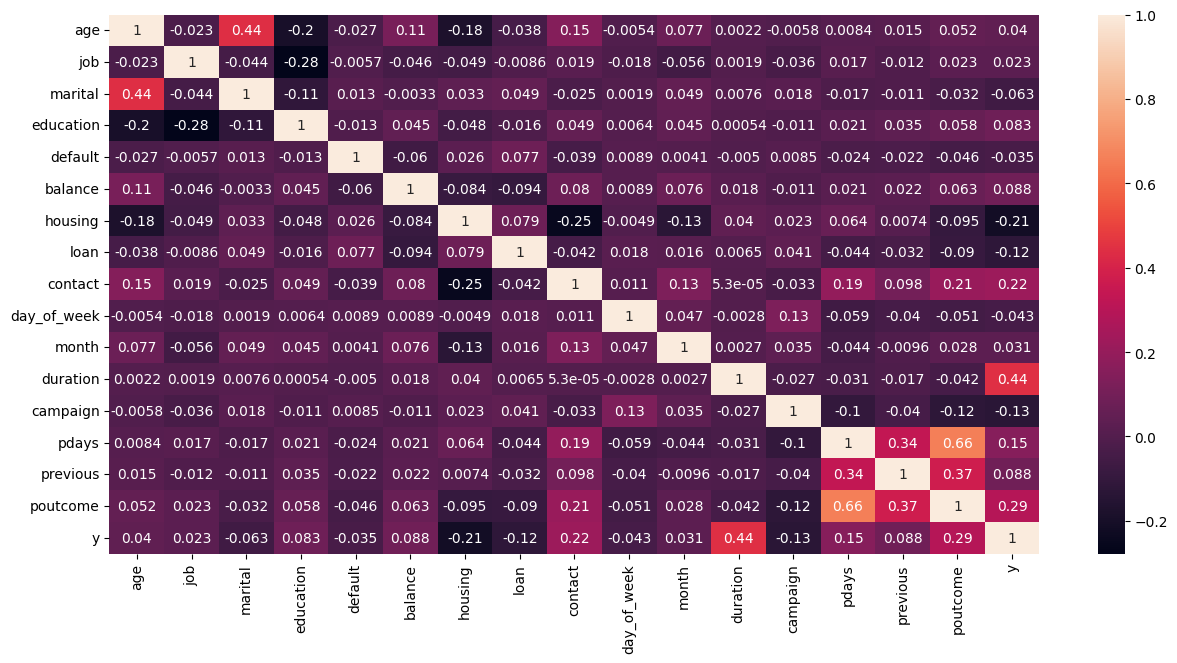

In [3]:
# Compute the correlation matrix
correlation_matrix = bankMarketing.corr()
# Display the correlation matrix as a heatmap
plt.figure(figsize=(15,7))
sns.heatmap(correlation_matrix, annot=True)

From the correlation matrix above, we can see that the highest correlated two features with the target variable are "poutcome" and "duration". 

# 1.1 Implementing Logistic Regression with most correlated 2 features

###  Choose the two most correlated features with target feature 'y'

In [4]:
XBankMarketingTwo = bankMarketing[["poutcome", "duration"]]
yBankMarketingTwo = bankMarketing['y']

In [5]:
# checking target values
print(yBankMarketingTwo.value_counts())

y
1    5289
2    5289
Name: count, dtype: int64


In [6]:
# converting 2's into 0's for the algorithm
yBankMarketingTwo = np.where(yBankMarketingTwo == 2, 0, yBankMarketingTwo)
yBankMarketingTwo = pd.Series(yBankMarketingTwo)
print(yBankMarketingTwo.value_counts())

1    5289
0    5289
Name: count, dtype: int64


###  * Define logistic regression model as class without using any built-in libraries
### * Define necessary functions such as sigmoid, fit, predict

In [7]:
import numpy as np

class LogisticRegression:
    def __init__(self, learningRate=0.01, iterations=1000, convergenceTolerance=1e-7):
        self.learningRate = learningRate
        self.iterations = iterations
        self.convergenceTolerance = convergenceTolerance
        self.weights = None
        self.bias = None
        self.lossHistory = [] # losses of each iteration, used for convergence check

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def computeLoss(self, y, predictions):
        """
        Binary Cross-Entropy Loss Function:
        L = -1/N * sum(y*log(predictions) + (1-y)*log(1-predictions))
        """
        n = len(y)
        return -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
        # a small constant (1e-15) added to avoid log(0) (undefined)


    def fit(self, X, y):
        # initializing weights and bias as zeros
        sampleCount, featureCount = X.shape
        self.weights = np.zeros(featureCount)
        self.bias = 0

        for i in range(self.iterations):
            # getting the linear product
            linearProduct = np.dot(X, self.weights) + self.bias
            # applying sigmoid function
            predictions = self.sigmoid(linearProduct)

            # calculating gradients of the loss function (dL/dw and dL/db)
            dw = (1 / sampleCount) * np.dot(X.T, (predictions - y))  # dL/dw
            db = (1 / sampleCount) * np.sum(predictions - y)        # dL/db

            # updating weights and bias
            self.weights -= self.learningRate * dw
            self.bias -= self.learningRate * db

            # calculating the loss for the current iteration and adding into lossHistory
            loss = self.computeLoss(y, predictions)
            self.lossHistory.append(loss)

            # checking for convergence
            if i > 0 and abs(self.lossHistory[-2] - loss) < self.convergenceTolerance:
                print(f"Converged after {i} iterations.")
                break

    def predict(self, X, threshold=0.5):
        linearProduct = np.dot(X, self.weights) + self.bias
        probabilities = self.sigmoid(linearProduct)
        # converting probabilities to binary labels
        return (probabilities >= threshold).astype(int)


Split the dataset into a training set and a validation set (80% training and 20% validation).

In [8]:
yBankMarketingTwo.name = "y" 
combined = pd.concat([XBankMarketingTwo, yBankMarketingTwo], axis=1)

# shuffling for a random split
combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)

X_shuffledBankMarketingTwo = combined[["poutcome", "duration"]]
y_shuffledBankMarketingTwo = combined["y"]

splitIndex = int(len(X_shuffledBankMarketingTwo) * 0.8)

X_trainBankMarketingTwo = X_shuffledBankMarketingTwo[:splitIndex]
y_trainBankMarketingTwo = y_shuffledBankMarketingTwo[:splitIndex]
X_testBankMarketingTwo = X_shuffledBankMarketingTwo[splitIndex:]
y_testBankMarketingTwo = y_shuffledBankMarketingTwo[splitIndex:]

print("Training set size:", X_trainBankMarketingTwo.shape, y_trainBankMarketingTwo.shape)
print("Testing set size:", X_testBankMarketingTwo.shape, y_testBankMarketingTwo.shape)

Training set size: (8462, 2) (8462,)
Testing set size: (2116, 2) (2116,)


Scale the features using StandardScaler

In [9]:
X_combined = pd.concat([X_trainBankMarketingTwo, X_testBankMarketingTwo])

# Calculating means and standard deviations
featureMeans = X_combined.mean(axis=0)
featureStds = X_combined.std(axis=0)

# Standardizing the training and testing features
X_trainBankMarketingTwo = (X_trainBankMarketingTwo - featureMeans) / featureStds
X_testBankMarketingTwo = (X_testBankMarketingTwo - featureMeans) / featureStds

* Initialize and train the custom logistic regression model

In [10]:
logr = LogisticRegression(learningRate=0.1, iterations=1000, convergenceTolerance=1e-7)

# training
logr.fit(X_trainBankMarketingTwo, y_trainBankMarketingTwo)

print("Weights:", logr.weights)
print("Bias:", logr.bias)

Converged after 699 iterations.
Weights: [-0.83296974 -1.61670116]
Bias: -0.19555658933170875


* Make predictions on the validation set

In [11]:
y_predBankMarketingTwo = logr.predict(X_testBankMarketingTwo)
print("Predictions:", y_predBankMarketingTwo)

Predictions: [0 0 1 ... 0 1 0]


### Evaluate the model's performance, print classification report and confusion matrix

In [12]:
def evaluate_model(y_true, y_pred):
    # Confusion Matrix
    TP = ((y_true == 1) & (y_pred == 1)).sum()
    TN = ((y_true == 0) & (y_pred == 0)).sum()
    FP = ((y_true == 0) & (y_pred == 1)).sum()
    FN = ((y_true == 1) & (y_pred == 0)).sum()

    # Classification Metrics
    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print Confusion Matrix
    print("Confusion Matrix:")
    print(f"TP: {TP}, FP: {FP}")
    print(f"FN: {FN}, TN: {TN}\n")

    # Print Classification Report
    print("Classification Report:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

    return accuracy, precision, recall, f1_score

evaluate_model(y_testBankMarketingTwo, y_predBankMarketingTwo)


Confusion Matrix:
TP: 865, FP: 313
FN: 171, TN: 767

Classification Report:
Accuracy: 0.77
Precision: 0.73
Recall: 0.83
F1 Score: 0.78


(0.7712665406427222, 0.734295415959253, 0.834942084942085, 0.7813911472448057)

### Print decision boundaries

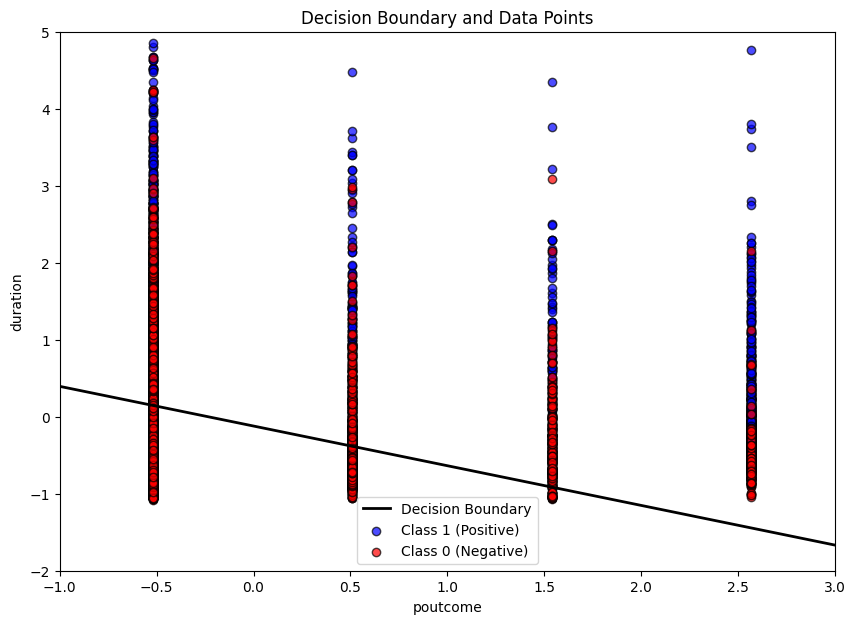

In [13]:
# Function to plot the decision boundary
def plot_decision_boundary(X, y, weights, bias, xlabel, ylabel):
    slope = -weights[0] / weights[1]
    intercept = -bias / weights[1]
    # Creating a range of x values
    x_values = np.linspace(X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1, 100)
    # Calculating corresponding y values for the decision boundary
    y_values = slope * x_values + intercept

    # The plot
    plt.figure(figsize=(10, 7))
    
    # Plotting the decision boundary
    plt.plot(x_values, y_values, color='black', linewidth=2, label='Decision Boundary')

    plt.xlim([-1, 3])  # Adjust based on your data range for 'poutcome'
    plt.ylim([-2, 5])  # Adjust based on your data range for 'duration'

    class_1 = X[y == 0]
    class_0 = X[y == 1]
    
    # Plotting the data points with specific colors
    plt.scatter(class_1.iloc[:, 0], class_1.iloc[:, 1], color='blue', edgecolors='k', label='Class 1 (Positive)', alpha=0.7)
    plt.scatter(class_0.iloc[:, 0], class_0.iloc[:, 1], color='red', edgecolors='k', label='Class 0 (Negative)', alpha=0.7)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('Decision Boundary and Data Points')
    plt.legend()
    plt.show()

# Plot the decision boundary using the selected features and trained model
plot_decision_boundary(X_trainBankMarketingTwo, y_trainBankMarketingTwo, logr.weights, logr.bias, "poutcome", "duration")

# 1.2 Implementing Logistic Regression using all features.

* Redefining input and target variables. (Using all input features in the dataset.)

In [14]:
XBankMarketingAll = bankMarketing.drop(columns=["y"])
yBankMarketingAll = bankMarketing['y']

In [15]:
# converting 2's into 0's for the algorithm
yBankMarketingAll = np.where(yBankMarketingAll == 2, 0, yBankMarketingAll)
yBankMarketingAll = pd.Series(yBankMarketingAll)
print(yBankMarketingAll.value_counts())

1    5289
0    5289
Name: count, dtype: int64


* Split the dataset into a training set and a validation set (80% training and 20% validation).

In [16]:
yBankMarketingAll.name = "y" 
combined = pd.concat([XBankMarketingAll, yBankMarketingAll], axis=1)

# shuffling for a random split
combined = combined.sample(frac=1, random_state=41).reset_index(drop=True)

X_shuffledBankMarketingAll = combined.drop(columns=["y"])
y_shuffledBankMarketingAll = combined["y"]

splitIndex = int(len(X_shuffledBankMarketingAll) * 0.8)

X_trainBankMarketingAll = X_shuffledBankMarketingAll[:splitIndex]
y_trainBankMarketingAll = y_shuffledBankMarketingAll[:splitIndex]
X_testBankMarketingAll = X_shuffledBankMarketingAll[splitIndex:]
y_testBankMarketingAll = y_shuffledBankMarketingAll[splitIndex:]

print("Training set size:", X_trainBankMarketingAll.shape, y_trainBankMarketingAll.shape)
print("Testing set size:", X_testBankMarketingAll.shape, y_testBankMarketingAll.shape)

Training set size: (8462, 16) (8462,)
Testing set size: (2116, 16) (2116,)


* Scale the features using StandardScaler

In [17]:
X_combined = pd.concat([X_trainBankMarketingAll, X_testBankMarketingAll])

# Calculating means and standard deviations
featureMeans = X_combined.mean(axis=0)
featureStds = X_combined.std(axis=0)

# Standardizing the training and testing features
X_trainBankMarketingAll = (X_trainBankMarketingAll - featureMeans) / featureStds
X_testBankMarketingAll = (X_testBankMarketingAll - featureMeans) / featureStds

### Initialize and train the custom logistic regression model.

In [18]:
logrAll = LogisticRegression(learningRate=0.1, iterations=1000, convergenceTolerance=1e-7)

# training
logrAll.fit(X_trainBankMarketingAll, y_trainBankMarketingAll)

print("Weights:", logrAll.weights)
print("Bias:", logrAll.bias)

Converged after 896 iterations.
Weights: [ 8.53992069e-04 -3.72628066e-02  9.28687912e-02 -1.84124380e-01
  2.32467320e-02 -1.44581012e-01  5.03887313e-01  2.30971990e-01
 -4.16795018e-01  6.99269294e-02  7.23902535e-02 -1.81070229e+00
  3.38799632e-01  1.33585138e-01  3.53280941e-02 -8.46713793e-01]
Bias: -0.15592463504582432


* Make predictions on the validation set

In [19]:
y_predBankMarketingAll = logrAll.predict(X_testBankMarketingAll)
print("Predictions:", y_predBankMarketingAll)

Predictions: [0 0 1 ... 1 1 1]


### Evaluate the model's performance, print classification report and confusion matrix 

In [20]:
logrAllReport = evaluate_model(y_testBankMarketingAll, y_predBankMarketingAll)

Confusion Matrix:
TP: 890, FP: 232
FN: 165, TN: 829

Classification Report:
Accuracy: 0.81
Precision: 0.79
Recall: 0.84
F1 Score: 0.82


### Briefly explain the impact of the number of features on the learning ability of the model.

Including all of the features resulted in a better classification with better results for each of the TP, FP, FN, TN values. Hence, all of the evaluation metrics (accuracy, precision, recall, f1-score) increased.

### After completing the SVM and logistic regression parts, the best results of the experiments with the SVM and Logistic regression models will be compared in a table.

The Cell for this is at the end of the SVM part!!!

# 2. Support Vector Machine

* Define your SVM model using sklearn

In [21]:
from sklearn.svm import SVC

# Define the SVM model with default parameters
svmModel = SVC()

## 2.1 implementing svm with grid search cv using all features

* Define features and target variable, you will use all features of dataset in this task

In [22]:
XBankMarketingAllSVM = XBankMarketingAll.copy()
yBankMarketingAllSVM = yBankMarketingAll.copy()

* Split the dataset into a training set and a validation set (80% training and 20% validation).

In [23]:
yBankMarketingAllSVM.name = "y" 
combined = pd.concat([XBankMarketingAllSVM, yBankMarketingAllSVM], axis=1)

# shuffling for a random split
combined = combined.sample(frac=1, random_state=40).reset_index(drop=True)

X_shuffledBankMarketingAllSVM = combined.drop(columns=["y"])
y_shuffledBankMarketingAllSVM = combined["y"]

splitIndex = int(len(X_shuffledBankMarketingAllSVM) * 0.8)

X_trainBankMarketingAllSVM = X_shuffledBankMarketingAllSVM[:splitIndex]
y_trainBankMarketingAllSVM = y_shuffledBankMarketingAllSVM[:splitIndex]
X_testBankMarketingAllSVM = X_shuffledBankMarketingAllSVM[splitIndex:]
y_testBankMarketingAllSVM = y_shuffledBankMarketingAllSVM[splitIndex:]

print("Training set size:", X_trainBankMarketingAllSVM.shape, y_trainBankMarketingAllSVM.shape)
print("Testing set size:", X_testBankMarketingAllSVM.shape, y_testBankMarketingAllSVM.shape)

Training set size: (8462, 16) (8462,)
Testing set size: (2116, 16) (2116,)


* Scale the features using StandardScaler

In [24]:
X_combined = pd.concat([X_trainBankMarketingAllSVM, X_testBankMarketingAllSVM])

# Calculating means and standard deviations
featureMeans = X_combined.mean(axis=0)
featureStds = X_combined.std(axis=0)

# Standardizing the training and testing features
X_trainBankMarketingAllSVM = (X_trainBankMarketingAllSVM - featureMeans) / featureStds
X_testBankMarketingAllSVM = (X_testBankMarketingAllSVM - featureMeans) / featureStds

#### Implement GridSearchCV

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

* Initialize the SVM classifier

In [26]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],  # Test different kernel functions
    'C': [0.1, 1, 10],              # Regularization parameter
    'gamma': ['scale', 'auto'],          # Kernel coefficient (for 'rbf' and 'poly')
    'degree': [2, 3, 4]                  # Degree of the polynomial kernel
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svmModel, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit GridSearchCV on the training set
grid_search.fit(X_trainBankMarketingAllSVM, y_trainBankMarketingAllSVM)

# Print the best parameters and the best score from GridSearchCV
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8281710673486572


* Train the SVM classifier with the best parameters found from grid search


In [27]:
# Extract the best parameters from GridSearchCV
best_params = grid_search.best_params_
# Train a new SVM classifier with the best parameters
svm_best = SVC(**best_params)
svm_best.fit(X_trainBankMarketingAllSVM, y_trainBankMarketingAllSVM)


SVC(C=1, degree=2, gamma='auto')

* Make predictions on the validation set using the best model


In [28]:
# Predict on the test set
y_pred_test = svm_best.predict(X_testBankMarketingAllSVM)

#### Evaluate the model's performance, print classification report and confusion matrix and best parameters found from GridSearchCV

In [29]:
# Evaluate the model
print("Test Set Evaluation:")
svm_accuracy = accuracy_score(y_testBankMarketingAllSVM, y_pred_test)
print("Accuracy:", accuracy_score(y_testBankMarketingAllSVM, y_pred_test))
svm_report = classification_report(y_testBankMarketingAllSVM, y_pred_test, output_dict=True)
print("Classification Report:\n", classification_report(y_testBankMarketingAllSVM, y_pred_test))

Test Set Evaluation:
Accuracy: 0.8260869565217391
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      1062
           1       0.85      0.79      0.82      1054

    accuracy                           0.83      2116
   macro avg       0.83      0.83      0.83      2116
weighted avg       0.83      0.83      0.83      2116



## 2.2 implementing svm with most correlated 2 features

#### Choose the two most correlated features with target feature 'y'

In [30]:
XBankMarketingTwoSVM = XBankMarketingTwo.copy()
yBankMarketingTwoSVM = yBankMarketingTwo.copy()

* Split the dataset into a training set and a validation set (80% training and 20% validation).

In [31]:
# shuffling for a random split
combined = pd.concat([XBankMarketingTwoSVM, yBankMarketingTwoSVM], axis=1)
combined = combined.sample(frac=1, random_state=39).reset_index(drop=True)

X_shuffledBankMarketingTwoSVM = combined[["poutcome", "duration"]]
y_shuffledBankMarketingTwoSVM = combined["y"]

splitIndex = int(len(X_shuffledBankMarketingTwoSVM) * 0.8)

X_trainBankMarketingTwoSVM = X_shuffledBankMarketingTwoSVM[:splitIndex]
y_trainBankMarketingTwoSVM = y_shuffledBankMarketingTwoSVM[:splitIndex]
X_testBankMarketingTwoSVM = X_shuffledBankMarketingTwoSVM[splitIndex:]
y_testBankMarketingTwoSVM = y_shuffledBankMarketingTwoSVM[splitIndex:]

print("Training set size:", X_trainBankMarketingTwoSVM.shape, y_trainBankMarketingTwoSVM.shape)
print("Testing set size:", X_testBankMarketingTwoSVM.shape, y_testBankMarketingTwoSVM.shape)

Training set size: (8462, 2) (8462,)
Testing set size: (2116, 2) (2116,)


* Scale the features using StandardScaler

In [32]:
X_combined = pd.concat([X_trainBankMarketingTwoSVM, X_testBankMarketingTwoSVM])

# Calculating means and standard deviations
featureMeans = X_combined.mean(axis=0)
featureStds = X_combined.std(axis=0)

# Standardizing the training and testing features
X_trainBankMarketingTwoSVM = (X_trainBankMarketingTwoSVM - featureMeans) / featureStds
X_testBankMarketingTwoSVM = (X_testBankMarketingTwoSVM - featureMeans) / featureStds

*  Initialize the SVM classifier, assign 'C' and 'kernel' parameters from the best hyperparameters found from GridSearchCV

In [33]:
svm_bestTwo = SVC(**best_params)

* Train the SVM classifier

In [34]:
svm_bestTwo.fit(X_trainBankMarketingTwoSVM, y_trainBankMarketingTwoSVM)

SVC(C=1, degree=2, gamma='auto')

* Make predictions on the validation set

In [35]:
y_pred_testTwo = svm_bestTwo.predict(X_testBankMarketingTwoSVM)

#### Evaluate the model's performance, print classification report and confusion matrix

In [36]:
# Evaluate the model
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_testBankMarketingTwoSVM, y_pred_testTwo))
print("Classification Report:\n", classification_report(y_testBankMarketingTwoSVM, y_pred_testTwo))

Test Set Evaluation:
Accuracy: 0.7589792060491494
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.69      0.75      1104
           1       0.71      0.84      0.77      1012

    accuracy                           0.76      2116
   macro avg       0.77      0.76      0.76      2116
weighted avg       0.77      0.76      0.76      2116



##### Visualize decision boundary and support vectors

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


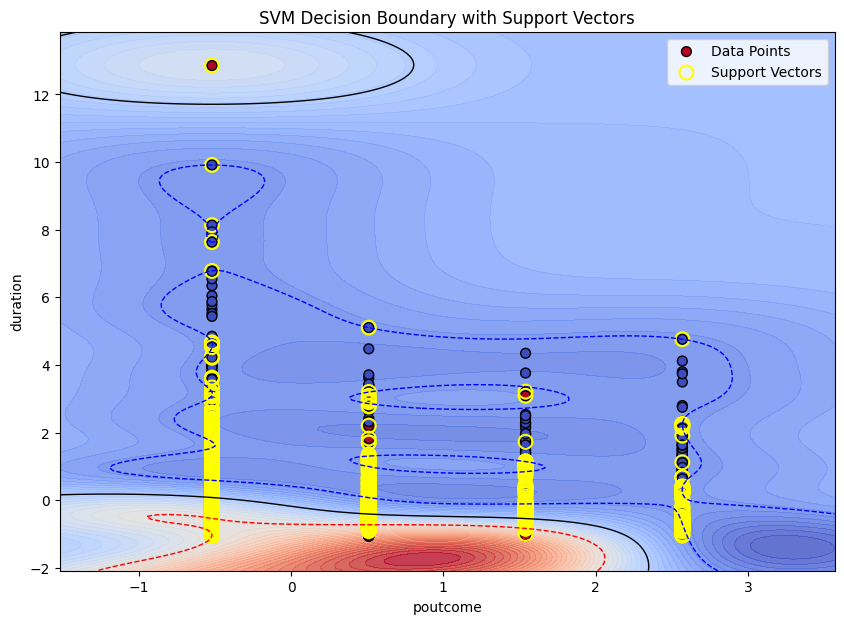

In [37]:
def plot_svm_decision_boundary(X, y, model, xlabel, ylabel):
    # Create a mesh grid for plotting
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    
    # Predict on the grid points
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary and margins
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50), cmap='coolwarm', alpha=0.8)
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['blue', 'black', 'red'], linestyles=['--', '-', '--'], linewidths=1)

    # Plot data points
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=50, label="Data Points")
    
    # Highlight the support vectors
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, facecolors='none', edgecolor='yellow', label="Support Vectors", linewidth=1.5)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("SVM Decision Boundary with Support Vectors")
    plt.legend()
    plt.show()

plot_svm_decision_boundary(X_trainBankMarketingTwoSVM, y_trainBankMarketingTwoSVM, svm_bestTwo, "poutcome", "duration")

## 2.3 implementing svm with least correlated 2 features

#### Choose the two least correlated features with target feature 'y'

In [38]:
XBankMarketingLeastTwoSVM = bankMarketing[["job", "default"]]
yBankMarketingLeastTwoSVM = bankMarketing['y']

* Split the dataset into a training set and a validation set (80% training and 20% validation).

In [39]:
yBankMarketingLeastTwoSVM.name = "y" 
combined = pd.concat([XBankMarketingLeastTwoSVM, yBankMarketingLeastTwoSVM], axis=1)

# shuffling for a random split
combined = combined.sample(frac=1, random_state=38).reset_index(drop=True)

X_shuffledBankMarketingLeastTwoSVM = combined[["job", "default"]]
y_shuffledBankMarketingLeastTwoSVM = combined["y"]

splitIndex = int(len(X_shuffledBankMarketingLeastTwoSVM) * 0.8)

X_trainBankMarketingLeastTwoSVM = X_shuffledBankMarketingLeastTwoSVM[:splitIndex]
y_trainBankMarketingLeastTwoSVM = y_shuffledBankMarketingLeastTwoSVM[:splitIndex]
X_testBankMarketingLeastTwoSVM = X_shuffledBankMarketingLeastTwoSVM[splitIndex:]
y_testBankMarketingLeastTwoSVM = y_shuffledBankMarketingLeastTwoSVM[splitIndex:]

print("Training set size:", X_trainBankMarketingLeastTwoSVM.shape, y_trainBankMarketingLeastTwoSVM.shape)
print("Testing set size:", X_testBankMarketingLeastTwoSVM.shape, y_testBankMarketingLeastTwoSVM.shape)

Training set size: (8462, 2) (8462,)
Testing set size: (2116, 2) (2116,)


* Scale the features using StandardScaler

In [40]:
X_combined = pd.concat([X_trainBankMarketingLeastTwoSVM, X_testBankMarketingLeastTwoSVM])

# Calculating means and standard deviations
featureMeans = X_combined.mean(axis=0)
featureStds = X_combined.std(axis=0)

# Standardizing the training and testing features
X_trainBankMarketingLeastTwoSVM = (X_trainBankMarketingLeastTwoSVM - featureMeans) / featureStds
X_testBankMarketingLeastTwoSVM = (X_testBankMarketingLeastTwoSVM - featureMeans) / featureStds

*  Initialize the SVM classifier, assign 'C' and 'kernel' parameters from the best hyperparameters you found from GridSearchCV

In [41]:
svm_bestTwoLeast = SVC(**best_params)

* Train the SVM classifier

In [42]:
svm_bestTwoLeast.fit(X_trainBankMarketingLeastTwoSVM, y_trainBankMarketingLeastTwoSVM)

SVC(C=1, degree=2, gamma='auto')

* Make predictions on the validation set

In [43]:
y_pred_testTwoLeast = svm_bestTwoLeast.predict(X_testBankMarketingLeastTwoSVM)

#### Evaluate the model's performance, print classification report and confusion matrix 

In [44]:
# Evaluate the model
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_testBankMarketingLeastTwoSVM, y_pred_testTwoLeast))
print("Classification Report:\n", classification_report(y_testBankMarketingLeastTwoSVM, y_pred_testTwoLeast))

Test Set Evaluation:
Accuracy: 0.5685255198487713
Classification Report:
               precision    recall  f1-score   support

           1       0.56      0.55      0.55      1027
           2       0.58      0.59      0.58      1089

    accuracy                           0.57      2116
   macro avg       0.57      0.57      0.57      2116
weighted avg       0.57      0.57      0.57      2116



##### Visualize decision boundary and support vectors

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


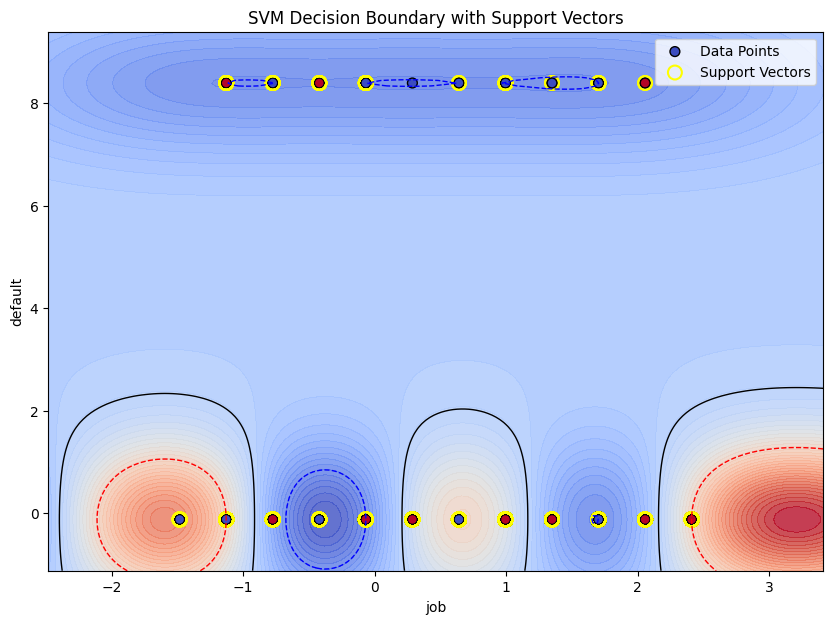

In [45]:
plot_svm_decision_boundary(X_trainBankMarketingLeastTwoSVM, y_trainBankMarketingLeastTwoSVM, svm_bestTwoLeast, "job", "default")

Logistic Regression vs SVM Report:

In [46]:
from tabulate import tabulate

# extracting metrics from reports
logr_accuracy = logrAllReport[0]
logr_precision = logrAllReport[1]
logr_recall = logrAllReport[2]
logr_f1 = logrAllReport[3]

svm_precision = svm_report['weighted avg']['precision']
svm_recall = svm_report['weighted avg']['recall']
svm_f1 = svm_report['weighted avg']['f1-score']

results = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Logistic Regression": [logr_accuracy, logr_precision, logr_recall, logr_f1],
    "SVM": [svm_accuracy, svm_precision, svm_recall, svm_f1]
}

# Create a DataFrame for the table
comparison_table = pd.DataFrame(results)

# Convert to a pretty table
print(tabulate(comparison_table, headers='keys', tablefmt='pretty'))

+---+-----------+---------------------+--------------------+
|   |  Metric   | Logistic Regression |        SVM         |
+---+-----------+---------------------+--------------------+
| 0 | Accuracy  | 0.8123818525519849  | 0.8260869565217391 |
| 1 | Precision | 0.7932263814616756  | 0.8275599858881537 |
| 2 |  Recall   | 0.8436018957345972  | 0.8260869565217391 |
| 3 | F1-Score  | 0.8176389526871842  | 0.8258629067378771 |
+---+-----------+---------------------+--------------------+


Here, for both models the versions that include all of the features gave the best result and hence they have compared at the table above.

The SVM performed slightly better in terms of evaluation metrics. Also, it's clear that SVM has more balanced metric distribution. It's because we used rbf kernels for the SVM model and Logistic Regression relies on a linear seperator. That helps SVM to create a more balanced classification compared to Logistic Regression.

# 3. Decision Tree

* Define the decision tree model using sklearn. And define other necessary modules for visualize the decision tree

In [47]:
weightsBMI=pd.read_csv("weights_bmi_6classes_updated.csv", encoding="utf-8")
weightsBMI.head()

,BMI_CLASS,UNIT_NUM,STUB_NAME_NUM,STUB_LABEL_NUM,YEAR_NUM,AGE_NUM,ESTIMATE,SE,FLAG
0,1,1,1,1.1,1,1.0,41.6,0.8,0
1,1,1,1,1.1,2,1.0,33.0,0.8,0
2,1,1,1,1.1,3,1.0,32.3,0.7,0
3,1,1,1,1.1,4,1.0,31.6,0.8,0
4,1,1,1,1.1,5,1.0,30.8,0.7,0


* Define features and target variable, using all features of dataset in this part

In [48]:
X_weightsBMI = weightsBMI.drop(columns=["BMI_CLASS"])  
y_weightsBMI = weightsBMI["BMI_CLASS"]                

* Split the dataset into a training set and a validation set (80% training and 20% validation).

In [49]:
from sklearn.model_selection import train_test_split

X_trainWeightsBMI, X_testWeightsBMI, y_trainWeightsBMI, y_testWeightsBMI = train_test_split(X_weightsBMI, y_weightsBMI, test_size=0.2, random_state=37)

# Check the sizes of the splits
print("Training Features Shape:", X_trainWeightsBMI.shape)
print("Testing Features Shape:", X_testWeightsBMI.shape)
print("Training Target Shape:", y_trainWeightsBMI.shape)
print("Testing Target Shape:", y_testWeightsBMI.shape)

Training Features Shape: (2688, 8)
Testing Features Shape: (672, 8)
Training Target Shape: (2688,)
Testing Target Shape: (672,)


* Initialize the Decision Tree classifier

In [50]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=37)

* Train the Decision Tree classifier

In [51]:
dt.fit(X_trainWeightsBMI, y_trainWeightsBMI)

DecisionTreeClassifier(random_state=37)

* Make predictions on the validation set

In [52]:
y_predWeightsBMI = dt.predict(X_testWeightsBMI)

#### Evaluate the model's performance, print classification report and confusion matrix

Classification Report:
              precision    recall  f1-score   support

           1       0.52      0.63      0.57       119
           2       0.80      0.83      0.82       112
           3       0.74      0.79      0.76       112
           4       0.82      0.75      0.78       106
           5       0.76      0.69      0.72       106
           6       0.80      0.68      0.74       117

    accuracy                           0.73       672
   macro avg       0.74      0.73      0.73       672
weighted avg       0.74      0.73      0.73       672



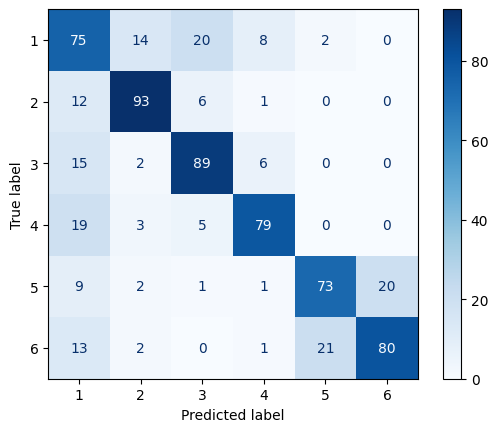

In [53]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Print the classification report
print("Classification Report:")
print(classification_report(y_testWeightsBMI, y_predWeightsBMI))

conf_matrix = confusion_matrix(y_testWeightsBMI, y_predWeightsBMI)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dt.classes_)
disp.plot(cmap="Blues")

#### Visualize the Decision Tree


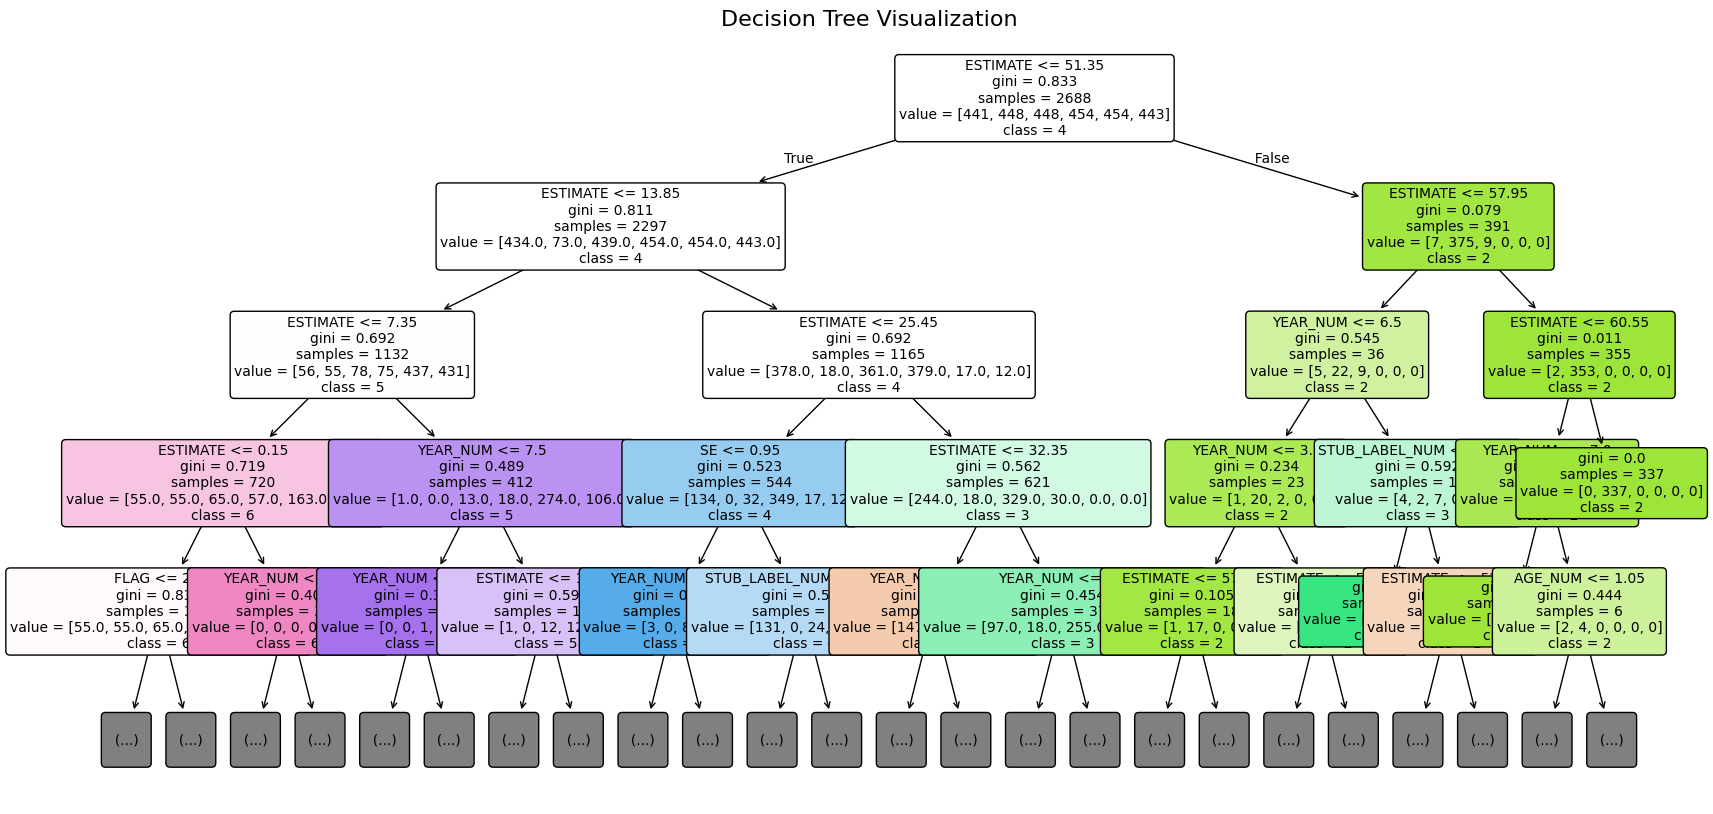

In [54]:
from sklearn.tree import plot_tree

# Plot the Decision Tree
plt.figure(figsize=(20, 10))  
plot_tree(
    dt, 
    feature_names=X_testWeightsBMI.columns,  # Use feature names
    class_names=[str(cls) for cls in dt.classes_],  # Show class names
    max_depth=4,   # Max-depth for better plotting
    filled=True,  # Fill nodes with colors
    rounded=True,  # Rounded edges for readability
    fontsize=10,   # Adjust font size for better visibility
)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()


### Guiding Question: What is the role of gini in decision tree?

Gini Index tells us how data is distributed to classes, a 0 gini index indicates exact one class label distribution and a 1 gini index indicates absolute even distribution of classes.

Gini Index is used to determine branching for decision trees. It finds best feature to split the data. The best is chosen to be with the one with the lowest gini score so that after the split it gains most information and can classify better.